>**Google colab notebook regarding diploma thesis: <br>Application of deep learning methods regarding weather forecast**

> This notebook presents snippet of work we have done using Support Vector Machines (SVM).

>At first we load and process the data, then we train SVM with Radial basis function as kernel. <br>
Later we present our success, or lack of it, with SVM's used for classification of cloud coverage.<br>
>**Note:**
>results presented at the moment might not be exactly same as presented in official diploma thesis due to random sampling of data from dataset and possible changes in hyperparameters 


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Imports

In [0]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import cv2 as cv

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

Set enviroment variables and paths to data

In [0]:
PATH = '/content/gdrive/My Drive/formatted_pics2_224_rgb/'
PATH_TO_CSV = '/content/gdrive/My Drive/synops/df_9to8.csv'
PATH_TO_CODE = '/content/gdrive/My Drive/synops/'
NUM_CLASSES = 9
loader_df = pd.read_csv(PATH_TO_CSV)

Load image data. <br>Preprocess them, create dataframe with preprocessed images.<br>
Loading is executed from PATH setted up a few cells above

In [4]:
pht_dic = dict()
l = len(os.listdir(PATH))
print(l)
ind = 0
for img in os.listdir(PATH):
  if ind % 10 == 0:
    print(ind)
  ind+=1
  im_name = PATH +'/'+ img
  img_read = cv.imread(im_name)
  img_read = np.array(img_read, dtype=np.float64)
  img_read = img_read
  pht_dic[img] = [img_read]
formatted_df = pd.DataFrame.from_dict(pht_dic, orient='index').reset_index()

2731
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2

Join images with synops.<br>
As stated above, dataframe with synops contains image names and dataframe with images has column with image names.<br> That is how we can join them.

In [0]:
df = pd.merge(loader_df[['name','synop']], formatted_df, left_on=['name'], right_on=['index'], how='inner')
df.drop(columns=['index'], inplace=True)
df.rename(columns={0:'hst'}, inplace=True)

Prepare datasets<br>
Split dataframe from previous cell for training, validation and testing.<br> Do one-hot-encoding for synops.<br> In these cell we only create functions to do so, they are executed in next cell. 

In [0]:
class Dataset_split_encode:
  def __init__(self):
      pass
  def split_dataset(self, d, perc_to_use, perc_to_train):
      '''
      params:
      perc_to_use : size of dataset to use overall
      perc_to_train : percentage from sample of size 'perc_to_use' to use as train and validation data
      '''
      init_sample = d.sample(frac=perc_to_use)
      sample = init_sample.sample(frac=perc_to_train)
      print(sample.columns)
      complement_s = init_sample[~init_sample.name.isin(sample.name)]
      train, test = np.split(sample, [int(0.6*len(sample))])
      return train, test, complement_s
  
  def one_hot_encode(self, synop):
	    empty = np.array([0,]*NUM_CLASSES)
	    syn_int = int(synop)
	    encoded = empty.copy()
	    encoded[syn_int - 1] = 1
	    return encoded
  
  def do_one_hot(self, df):
      df.synop = df.synop.apply(lambda x: one_hot_encode(x))
      return df

Split datasets for SVM, we dont need to do one hot encoding as for cnn.

In [10]:
train, validate, test = Dataset_split_encode().split_dataset(df,0.8, 0.8)

x_train = np.array([x.reshape(-1) for x in train.hst.values]) 
y_traincm = np.array([x for x in train.synop.values])

x_testcm = np.array([x.reshape(-1) for x in test.hst.values]) 
y_testcm = np.array([x for x in test.synop.values]) 

Index([u'name', u'synop', u'hst'], dtype='object')


Code for plotting confusion matrices

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = range(0,9)#classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Create SVM using rbf kernel, grid search for hyperparameters

In [0]:
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# #############################################################################
# Load and prepare data set
#
# dataset for grid search
class Rbf_params():
  def __init__(self):
    pass
  def do_stuff(self, train):
    print(type(train.hst.values))
    #data.transpose(2,0,1).reshape(-1,data.shape[1])
    n_samples = len(train.hst.values)
    X = np.array([x.reshape( -1) for x in train.hst.values]) 
    y = np.array([x for x in train.synop.values]) 
    
    C_range = np.logspace(5, 7, 1)
    gamma_range = np.logspace(-8, -6, 1)
    # best C 316227.7660168379
    # best gamma 1e-07
    
    param_grid = dict(gamma=gamma_range, C=C_range)
		#print(param_grid)
    cv = StratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=42)
    print("grid search started")
    grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, verbose=12)
    grid.fit(X, y)
		
    print("The best parameters are %s with a score of %0.2f"
			% (grid.best_params_, grid.best_score_))

		
    scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
															len(gamma_range))

    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
				norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Validation accuracy')
    plt.savefig('svm_acc_rgb_test.png')
    plt.show()

Hyperparameters gridsearch

In [0]:
svm = Rbf_params()
svm.do_stuff(train)

<type 'numpy.ndarray'>
grid search started
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] C=100000.0, gamma=1e-08 .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... C=100000.0, gamma=1e-08, score=0.593301435407, total= 5.7min
[CV] C=100000.0, gamma=1e-08 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.3min remaining:    0.0s


[CV] .... C=100000.0, gamma=1e-08, score=0.511961722488, total= 5.7min
[CV] C=100000.0, gamma=1e-08 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.7min remaining:    0.0s


[CV] .... C=100000.0, gamma=1e-08, score=0.540669856459, total= 5.7min
[CV] C=100000.0, gamma=1e-08 .........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 28.0min remaining:    0.0s


[CV] .... C=100000.0, gamma=1e-08, score=0.535885167464, total= 5.9min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 37.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 37.5min finished


KeyboardInterrupt: ignored

Use best found hypeparams <br>
Hyperparameters used here were found during more extensive run than that above.

In [0]:
# using already preprocessed dataset
clf = SVC(gamma=0.0000001, C=316227.766)
clf.fit(x_train, y_traincm)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_testcm)

Reshape results needed for plotting confussion matrix

In [0]:
y_test_pred_cm =y_test_pred.reshape((-1,1))
y_train_pred_cm =y_train_pred.reshape((-1,1))
y_test_cm =y_testcm.reshape((-1,1))
y_train_cm =y_traincm.reshape((-1,1))

Plot confusion matrices

Normalized confusion matrix
Normalized confusion matrix


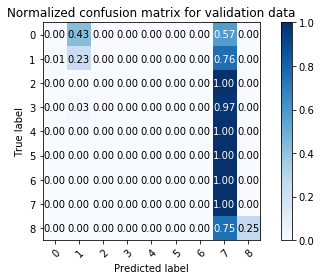

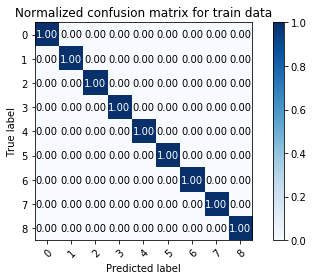

In [15]:
plot_confusion_matrix(y_test_cm, y_test_pred_cm, classes=range(0,8), normalize=True,
                      title='Normalized confusion matrix for validation data')
plot_confusion_matrix(y_train_cm, y_train_pred_cm, classes=range(0,8), normalize=True,
                     title='Normalized confusion matrix for train data')

plt.show()